In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os.path as op
import pandas as pd
from mriqc.viz.misc import raters_variability_plot, plot_abide_stripplots, plot_corrmat, plot_histograms

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
data_path = '/home/oesteban/Google Drive/mriqc'
x_path = op.join(data_path, 'aMRIQC_abide_20161130.csv')
y_path = op.join(data_path, 'ABIDE_QC_Marie.csv')

In [6]:
X = pd.read_csv(x_path, index_col=False)
cols = X.columns.ravel().tolist()
print(cols)
cols.remove('subject_id')
len(cols)

['subject_id', 'cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z', 'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range', 'qi_1', 'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'size_x', 'size_y', 'size_z', 'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm', 'spacing_x', 'spacing_y', 'spacing_z', 'summary_bg_k', 'summary_bg_mean', 'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mean', 'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mean', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mean', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv', 'tpm_overlap_csf', 'tpm_overlap_gm', 'tpm_overlap_wm', 'wm2max']


56

KeyError: "[u'Marie' u'PCP_rater_2' u'PCP_rater_3'] not in index"

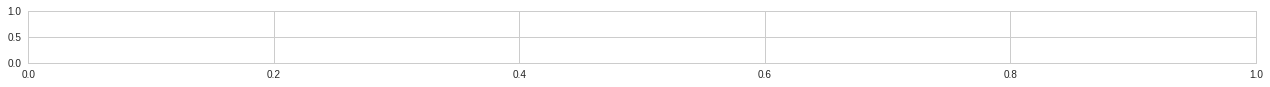

In [3]:
mdata = pd.read_csv(op.join(data_path, 'ABIDE_QC_all.csv'), index_col=False, na_values='n/a', na_filter=False)
fig = raters_variability_plot(mdata)

In [ ]:
fig = plot_abide_stripplots(x_path, y_path)

In [ ]:
fig = plot_corrmat(x_path)

In [ ]:
fig = plot_histograms(x_path, y_path)

In [4]:
import os.path as op
import pandas as pd
import numpy as np
loso = pd.read_csv(op.join(data_path, 'cv_loso.csv'), index_col=False, na_values='n/a', na_filter=False)
loso['Split'] = ['LoSo'] * len(loso[['clf']].values.ravel())
kfold = pd.read_csv(op.join(data_path, 'cv_kfold.csv'), index_col=False, na_values='n/a', na_filter=False)
kfold['Split'] = ['10-fold'] * len(kfold[['clf']].values.ravel())

cv = loso.append(kfold)
print(cv.shape)

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(7076001, 7)


In [17]:
cols = cv.columns.ravel().tolist()
print cols

['clf', 'split_id', 'zscored', 'roc_auc', 'mean_auc', 'params', 'Split']


In [11]:
cols.remove('params')
best_param = {}

for sp in ['LoSo', '10-fold']:
    split_cv = cv.loc[cv.Split.str.contains(sp)]
    for clf in ['svc_linear', 'svc_rbf', 'rfc']:
        clf_cv = split_cv.loc[split_cv.clf.str.contains(clf)]
        for zs in [0, 1]:
            subcv = clf_cv.loc[clf_cv.zscored == zs]
            # params = list(set(subcv.params.values.ravel().tolist()))
            
            max_val = subcv.mean_auc.values.max()
            maxdf = subcv.loc[subcv.mean_auc == max_val]
            bp = list(set(maxdf[['params']].values.ravel().tolist()))            
            p_auc = []
            for p in bp:
                p_auc.append(maxdf.loc[subcv.params.str.contains(p), 'roc_auc'].values.mean())
                print(maxdf.loc[subcv.params.str.contains(p), cols])
            

            print(sp, clf, zs, len(bp), max_val, np.max(p_auc))
            

               clf split_id zscored   roc_auc  mean_auc Split
844683  svc_linear        8       0  0.971429  0.900202  LoSo
844684  svc_linear        8       0   0.90411  0.900202  LoSo
844685  svc_linear        8       0         1  0.900202  LoSo
844686  svc_linear        8       0       0.7  0.900202  LoSo
844687  svc_linear        8       0  0.824561  0.900202  LoSo
844688  svc_linear        8       0         1  0.900202  LoSo
844689  svc_linear        8       0  0.970297  0.900202  LoSo
844690  svc_linear        8       0  0.964912  0.900202  LoSo
844691  svc_linear        8       0  0.685714  0.900202  LoSo
844692  svc_linear        8       0  0.868421  0.900202  LoSo
844693  svc_linear        8       0  0.722222  0.900202  LoSo
844694  svc_linear        8       0  0.966667  0.900202  LoSo
844695  svc_linear        8       0  0.946429  0.900202  LoSo
844696  svc_linear        8       0  0.730769  0.900202  LoSo
844697  svc_linear        8       0  0.890909  0.900202  LoSo
844698  

In [16]:
import seaborn as sn
data = cv.loc[cv.zscored == 0, ['clf', 'roc_auc', 'Split']]
ax = sn.violinplot(
    x='clf', y='roc_auc', hue='Split', data=data, split=True, inner="quart")

# ax.set_ylim([0.8, 1.1])
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Model')

AttributeError: 'float' object has no attribute 'shape'

In [ ]:
loso = pd.read_csv(op.join(data_path, 'loso-v2.0.csv'), index_col=False, na_values='n/a', na_filter=False)

In [ ]:
import numpy as np
loso_subset = loso[loso.zscored == 0]
params = list(set(loso_subset.params.values.ravel()))
for p in params:
    print(p, np.max(list(set(loso_subset[loso_subset.params == p].mean_auc.values.ravel().tolist()))))